### Load Libraries & Packages

In [1]:
import numpy as np
from scipy.integrate import odeint
from scipy.optimize import minimize
import pickle
import matplotlib.pyplot as plt
import time

### Import Data and State-Space Model

In [2]:
with open('HW2_Data.pickle', 'rb') as f:
    Data = pickle.load(f)
Ti = Data['Ti'][:6*24*2] # indoor air temperature in degC
To = Data['To'][:6*24*2] # outdoor air temperature in degC
q_solar = Data['q_solar'][:6*24*2] # absorbed solar radiation in W

with open('HW2_SS-Model.pickle', 'rb') as f:
    ss_model = pickle.load(f)
Ad = ss_model['Ad']
Bd = ss_model['Bd']
Cd = ss_model['Cd']
Dd = ss_model['Dd']

Bd_HVAC = Bd[:,:1]
Bd_dist = Bd[:,1:]
Dd_HVAC = Dd[:1]
Dd_dist = Dd[1:]

### Define functions

In [3]:
def compute_x(x0, u0_HVAC, u0_dist, 
              Ad, Bd_HVAC, Bd_dist):
    return np.dot(Ad,x0) + np.dot(Bd_HVAC,u0_HVAC) + np.dot(Bd_dist,u0_dist)

def compute_y(x0, u0_HVAC, u0_dist, 
              Cd, Dd_HVAC, Dd_dist):
    return np.dot(Cd,x0) + np.dot(Dd_HVAC,u0_HVAC) + np.dot(Dd_dist,u0_dist)

def MPC_simulation(x0,
                   Ad, Bd_HVAC, Bd_dist,
                   Cd, Dd_HVAC, Dd_dist,
                   u_dist,
                   setpoint_low, setpoint_high,
                   price, COP,
                   pred_horizon):
    N = u_dist.shape[0]
    x = np.zeros((N+1,2))
    y = np.zeros((N,1))
    u_HVAC = np.zeros((N,1))
    x[0,0] = x0[0] # initial Ti
    x[0,1] = x0[1] # initial Tw
    
    # simulation
    for i in range(N-1):
        t = time.time()
        u_HVAC[i,:] = optimization(x0=x[i,:],
                                   u_dist=u_dist[i:i+pred_horizon,:],
                                   setpoint_low=setpoint_low,
                                   setpoint_high=setpoint_high,
                                   price=price[i:i+pred_horizon],
                                   COP=COP[i:i+pred_horizon])
#         t_elapsed = time.time() - t
#         print('Elapsed time', t_elapsed)
        x[i+1,:] = compute_x(x[i:i+1,:].T,
                             u_HVAC[i:i+1,:].T,
                             u_dist[i:i+1,:].T,
                             Ad, Bd_HVAC, Bd_dist).flatten()
        y[i,:] = compute_y(x[i:i+1,:].T,
                           u_HVAC[i:i+1,:].T,
                           u_dist[i:i+1,:].T,
                           Cd, Dd_HVAC, Dd_dist).flatten()
    return x, y, u_HVAC

def optimization(x0, u_dist, setpoint_low, setpoint_high, price, COP):
    N = u_dist.shape[0] # number of timesteps
    
    init = -np.ones(N)*0.5 # initial value for the optimization below
    ans = minimize(objective,
                   init,
                   bounds=([[-2,0]]*N),
                   constraints=({'type': 'ineq',
                                 'fun': cons_low,
                                 'args': (x0, N, u_dist, setpoint_low)},
                                {'type': 'ineq',
                                 'fun': cons_high,
                                 'args':(x0, N, u_dist, setpoint_high)}
                               ),
                   args=(price, COP)
                   )
    return ans.x[0]*1000

# first constraint, air temperature low bound
def cons_low(u_HVAC, x0, N, u_dist, setpoint_low):
    u_HVAC = u_HVAC[:,None]*1000
    x = np.zeros((N+1,2))
    y = np.zeros((N,1))
    x[0,0] = x0[0] # initial Ti
    x[0,1] = x0[1] # initial Tw
    
    for i in range(N):
        x[i+1,:] = compute_x(x[i:i+1,:].T,
                             u_HVAC[i:i+1,:].T,
                             u_dist[i:i+1,:].T,
                             Ad, Bd_HVAC, Bd_dist).flatten()
        y[i,:] = compute_y(x[i:i+1,:].T,
                           u_HVAC[i:i+1,:].T,
                           u_dist[i:i+1,:].T,
                           Cd, Dd_HVAC, Dd_dist).flatten()
    
    return (y-setpoint_low).flatten()

# second constraint, air temperature upper bound
def cons_high(u_HVAC, x0, N, u_dist, setpoint_high):
    u_HVAC = u_HVAC[:,None]*1000
    x = np.zeros((N+1,2))
    y = np.zeros((N,1))
    x[0,0] = x0[0] # initial Ti
    x[0,1] = x0[1] # initial Tw
    
    for i in range(N):
        x[i+1,:] = compute_x(x[i:i+1,:].T,
                             u_HVAC[i:i+1,:].T,
                             u_dist[i:i+1,:].T,
                             Ad, Bd_HVAC, Bd_dist).flatten()
        y[i,:] = compute_y(x[i:i+1,:].T,
                           u_HVAC[i:i+1,:].T,
                           u_dist[i:i+1,:].T,
                           Cd, Dd_HVAC, Dd_dist).flatten()
    return (setpoint_high-y).flatten()

# objective function
def objective(u_HVAC, price, COP):
    return np.sum(-u_HVAC/COP/6 * price) # kW X (1/6 hour) / COP X Elec. Rate

# Electricity rates
def func_price(i):
    # $/kWh
    hour = (i//6)%24
    if hour<7:
        return 0.082
    elif (hour>=7)&(hour<11):
        return 0.113
    elif (hour>=11)&(hour<17):
        return 0.17
    elif (hour>=17)&(hour<19):
        return 0.113
    else:
        return 0.082

# HVAC COP
def func_COP(To):
    return -2/25 * To + 6

In [4]:
price = np.array([func_price(i) for i in range(q_solar.shape[0])])
COP = np.array([func_COP(i) for i in To])

### Optimization

In [5]:
x0 = [24,25.5] # initial states
u_dist = np.hstack((q_solar[:,None], To[:,None]))
setpoint_low=22 # air temperature low bound
setpoint_high=24 # air temperature upper bound
pred_horizon = 6 * 6 # 6-hour prediction horizon (1 timestep = 10 min., 6 timesteps = 1 hour, 6*6 timesteps = 6 hours)

x, y, u_HVAC = MPC_simulation(x0,
                              Ad, Bd_HVAC, Bd_dist,
                              Cd, Dd_HVAC, Dd_dist,
                              u_dist,
                              setpoint_low, setpoint_high,
                              price, COP,
                              pred_horizon)

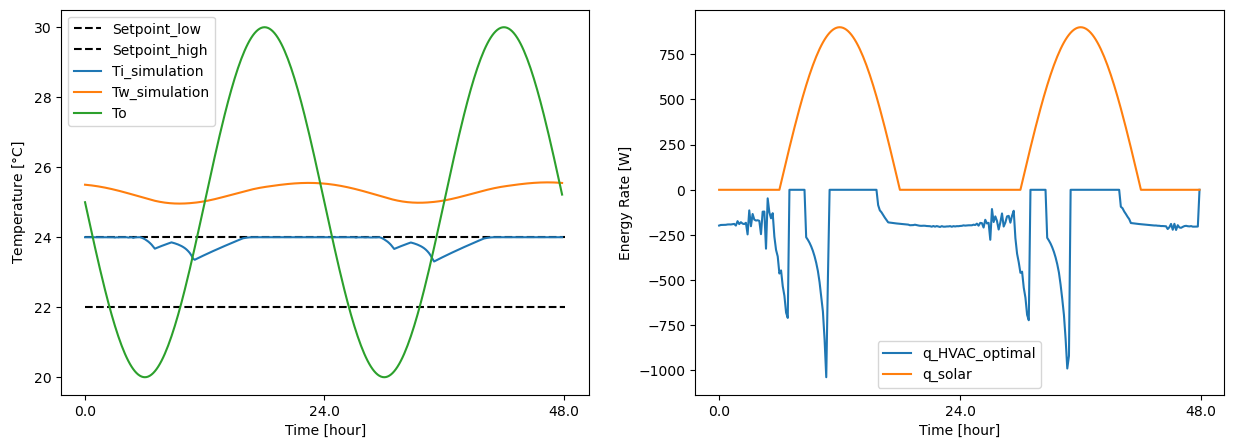

In [6]:
N = x.shape[0]
Ti_simulation = x[:,0] # Indoor temperature 
Tw_simulation = x[:,1]

# plotting
t_span = np.arange(0,N+1)
fig, ax = plt.subplots(1,2,figsize=(15,5))
ax[0].hlines(setpoint_low, 0, N, label='Setpoint_low', linestyle='--', color='k')
ax[0].hlines(setpoint_high, 0, N, label='Setpoint_high', linestyle='--', color='k')

ax[0].plot(Ti_simulation[:-1], label='Ti_simulation')
ax[0].plot(Tw_simulation[:-1], label='Tw_simulation')
ax[0].plot(To, label='To')
ax[0].set_xticks(t_span[::6*24],t_span[::6*24]*10/60)
ax[0].set_ylabel('Temperature [$\degree$C]')
ax[0].set_xlabel('Time [hour]')
ax[0].legend()

ax[1].plot(u_HVAC, label='q_HVAC_optimal')
ax[1].plot(q_solar, label='q_solar')
ax[1].set_xticks(t_span[::6*24],t_span[::6*24]*10/60)
ax[1].set_ylabel('Energy Rate [W]')
ax[1].set_xlabel('Time [hour]')
ax[1].legend()

plt.show()

In [7]:
print('Electricity cost: $', (-u_HVAC.flatten()/COP/6/1000*price).sum())

Electricity cost: $ 0.20984871423020712


In [8]:
# Temperature violation summed over timesteps
temp_violation = np.maximum(setpoint_low - Ti_simulation[:-1], 0) + np.maximum(Ti_simulation[:-1] - setpoint_high, 0)
print('Temperature violation sum:', temp_violation.sum())

Temperature violation sum: 1.0627232427395938e-10
